In [74]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import *
from collections import Counter
import pickle as pkl
import gradio as gr

# ========== LOAD DATA ==========

In [75]:
imsData = pd.read_csv("ikimina_loan_Dataset.csv")
imsData

,MemberID,SavingFrequency,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,Age,RecentLoanPaymentStatus,SavingStatus,SavingRatingFactor,SavingRatio,ExpectedLoan,BoostAmount,AllowedLoan
0,1,daily,1,365,348,40,8945993,2019,2020,employed,True,35,Excellent,Poor,0.2,0.11,1876601.98,488587.16,2365189.14
1,2,daily,1,365,106,21,706136,2019,2022,unemployed,True,35,Excellent,Poor,0.2,0.20,486301.21,184743.73,671044.94
2,3,daily,1,365,48,32,4131972,2017,2018,employed,False,35,Excellent,Good,0.6,0.67,18852122.25,8678771.07,8263944.00
3,4,daily,1,365,96,70,7388875,2017,2022,unemployed,False,35,Excellent,Good,0.6,0.73,16855871.09,6564765.20,14777750.00
4,5,daily,1,365,140,22,1318778,2022,2022,employed,True,64,Excellent,Poor,0.2,0.16,687648.53,275659.46,963307.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,monthly,15,180,32,11,5018194,2015,2017,unemployed,False,10,Poor,Poor,0.2,0.34,5645468.25,1752961.80,7398430.05
39996,39997,monthly,15,180,152,16,9704978,2017,2019,employed,True,4,Poor,Poor,0.2,0.11,2298547.42,331696.35,2630243.78
39997,39998,monthly,15,180,128,115,2448125,2017,2020,unemployed,True,4,Poor,Better,0.8,0.90,2754140.62,450342.92,3204483.55
39998,39999,monthly,15,180,96,40,1705139,2016,2016,employed,False,4,Poor,Bad,0.4,0.42,1278854.25,317377.52,1596231.77


In [76]:
print(imsData.shape)
print(imsData.columns)
imsData.head()


(40000, 19)
Index(['MemberID', 'SavingFrequency', 'SavingTimesPerPeriod',
       'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade',
       'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear',
       'EmploymentStatus', 'HasGuardian', 'Age', 'RecentLoanPaymentStatus',
       'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan',
       'BoostAmount', 'AllowedLoan'],
      dtype='object')


,MemberID,SavingFrequency,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,Age,RecentLoanPaymentStatus,SavingStatus,SavingRatingFactor,SavingRatio,ExpectedLoan,BoostAmount,AllowedLoan
0,1,daily,1,365,348,40,8945993,2019,2020,employed,True,35,Excellent,Poor,0.2,0.11,1876601.98,488587.16,2365189.14
1,2,daily,1,365,106,21,706136,2019,2022,unemployed,True,35,Excellent,Poor,0.2,0.20,486301.21,184743.73,671044.94
2,3,daily,1,365,48,32,4131972,2017,2018,employed,False,35,Excellent,Good,0.6,0.67,18852122.25,8678771.07,8263944.00
3,4,daily,1,365,96,70,7388875,2017,2022,unemployed,False,35,Excellent,Good,0.6,0.73,16855871.09,6564765.20,14777750.00
4,5,daily,1,365,140,22,1318778,2022,2022,employed,True,64,Excellent,Poor,0.2,0.16,687648.53,275659.46,963307.98


In [77]:
def enrich_features(df, current_year):
    df['AvgSavingPerCycle'] = df['TotalCurrentSaving'] / df['UserSavingsMade'].replace(0, 1)
    df['SavingRatio'] = df['UserSavingsMade'] / df['CompletedSavingCycles'].replace(0, 1)
    df['RemainingCycles'] = df['TotalSavingCycles'] - df['CompletedSavingCycles']
    df['RemainingRatio'] = df['RemainingCycles'] / df['TotalSavingCycles'].replace(0, 1)
    df['MembershipYears'] = current_year - df['UserJoinedYear']
    df['IkiminaAge'] = current_year - df['IkiminaCreatedYear']
    df['MembershipRatio'] = df['MembershipYears'] / df['IkiminaAge'].replace(0, 1)
    df['HasGuardian'] = df['HasGuardian'].astype(int)
    df['IsEmployed'] = df['EmploymentStatus'].apply(lambda x: 1 if x == 'employed' else 0)
    return df

imsData = enrich_features(imsData, current_year=2025)
imsData

,MemberID,SavingFrequency,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,...,ExpectedLoan,BoostAmount,AllowedLoan,AvgSavingPerCycle,RemainingCycles,RemainingRatio,MembershipYears,IkiminaAge,MembershipRatio,IsEmployed
0,1,daily,1,365,348,40,8945993,2019,2020,employed,...,1876601.98,488587.16,2365189.14,223649.825000,17,0.046575,5,6,0.833333,1
1,2,daily,1,365,106,21,706136,2019,2022,unemployed,...,486301.21,184743.73,671044.94,33625.523810,259,0.709589,3,6,0.500000,0
2,3,daily,1,365,48,32,4131972,2017,2018,employed,...,18852122.25,8678771.07,8263944.00,129124.125000,317,0.868493,7,8,0.875000,1
3,4,daily,1,365,96,70,7388875,2017,2022,unemployed,...,16855871.09,6564765.20,14777750.00,105555.357143,269,0.736986,3,8,0.375000,0
4,5,daily,1,365,140,22,1318778,2022,2022,employed,...,687648.53,275659.46,963307.98,59944.454545,225,0.616438,3,3,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,monthly,15,180,32,11,5018194,2015,2017,unemployed,...,5645468.25,1752961.80,7398430.05,456199.454545,148,0.822222,8,10,0.800000,0
39996,39997,monthly,15,180,152,16,9704978,2017,2019,employed,...,2298547.42,331696.35,2630243.78,606561.125000,28,0.155556,6,8,0.750000,1
39997,39998,monthly,15,180,128,115,2448125,2017,2020,unemployed,...,2754140.62,450342.92,3204483.55,21288.043478,52,0.288889,5,8,0.625000,0
39998,39999,monthly,15,180,96,40,1705139,2016,2016,employed,...,1278854.25,317377.52,1596231.77,42628.475000,84,0.466667,9,9,1.000000,1


In [78]:
imsData = enrich_features(imsData, current_year=2025)
print(imsData.head())


   MemberID SavingFrequency  SavingTimesPerPeriod  TotalSavingCycles  \
0         1           daily                     1                365   
1         2           daily                     1                365   
2         3           daily                     1                365   
3         4           daily                     1                365   
4         5           daily                     1                365   

   CompletedSavingCycles  UserSavingsMade  TotalCurrentSaving  \
0                    348               40             8945993   
1                    106               21              706136   
2                     48               32             4131972   
3                     96               70             7388875   
4                    140               22             1318778   

   IkiminaCreatedYear  UserJoinedYear EmploymentStatus  ...  ExpectedLoan  \
0                2019            2020         employed  ...    1876601.98   
1                2019 

In [79]:

def encode_features(df):
    cat_cols = ['SavingFrequency', 'RecentLoanPaymentStatus']
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
    
    df = df.drop(columns=cat_cols).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)
    return df


In [80]:
imsData = encode_features(imsData)
imsData

,MemberID,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,...,MembershipRatio,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,1,365,348,40,8945993,2019,2020,employed,1,...,0.833333,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,365,106,21,706136,2019,2022,unemployed,1,...,0.500000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,365,48,32,4131972,2017,2018,employed,0,...,0.875000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,365,96,70,7388875,2017,2022,unemployed,0,...,0.375000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,365,140,22,1318778,2022,2022,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,15,180,32,11,5018194,2015,2017,unemployed,0,...,0.800000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39996,39997,15,180,152,16,9704978,2017,2019,employed,1,...,0.750000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39997,39998,15,180,128,115,2448125,2017,2020,unemployed,1,...,0.625000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39998,39999,15,180,96,40,1705139,2016,2016,employed,0,...,1.000000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
print(imsData.columns.tolist())

['MemberID', 'SavingTimesPerPeriod', 'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade', 'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear', 'EmploymentStatus', 'HasGuardian', 'Age', 'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan', 'BoostAmount', 'AllowedLoan', 'AvgSavingPerCycle', 'RemainingCycles', 'RemainingRatio', 'MembershipYears', 'IkiminaAge', 'MembershipRatio', 'IsEmployed', 'SavingFrequency_daily', 'SavingFrequency_monthly', 'SavingFrequency_weekly', 'RecentLoanPaymentStatus_Bad', 'RecentLoanPaymentStatus_Better', 'RecentLoanPaymentStatus_Excellent', 'RecentLoanPaymentStatus_Good', 'RecentLoanPaymentStatus_Poor']


In [82]:
imsData

,MemberID,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,...,MembershipRatio,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,1,365,348,40,8945993,2019,2020,employed,1,...,0.833333,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,365,106,21,706136,2019,2022,unemployed,1,...,0.500000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,365,48,32,4131972,2017,2018,employed,0,...,0.875000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,365,96,70,7388875,2017,2022,unemployed,0,...,0.375000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,365,140,22,1318778,2022,2022,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,15,180,32,11,5018194,2015,2017,unemployed,0,...,0.800000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39996,39997,15,180,152,16,9704978,2017,2019,employed,1,...,0.750000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39997,39998,15,180,128,115,2448125,2017,2020,unemployed,1,...,0.625000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39998,39999,15,180,96,40,1705139,2016,2016,employed,0,...,1.000000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# ========== ENCODE season and location_type AS INTEGERS ==========

In [83]:
imsData

,MemberID,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,...,MembershipRatio,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,1,365,348,40,8945993,2019,2020,employed,1,...,0.833333,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,365,106,21,706136,2019,2022,unemployed,1,...,0.500000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,365,48,32,4131972,2017,2018,employed,0,...,0.875000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,365,96,70,7388875,2017,2022,unemployed,0,...,0.375000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,365,140,22,1318778,2022,2022,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,15,180,32,11,5018194,2015,2017,unemployed,0,...,0.800000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39996,39997,15,180,152,16,9704978,2017,2019,employed,1,...,0.750000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39997,39998,15,180,128,115,2448125,2017,2020,unemployed,1,...,0.625000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39998,39999,15,180,96,40,1705139,2016,2016,employed,0,...,1.000000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis

In [84]:
print(imsData.columns.tolist())


['MemberID', 'SavingTimesPerPeriod', 'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade', 'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear', 'EmploymentStatus', 'HasGuardian', 'Age', 'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan', 'BoostAmount', 'AllowedLoan', 'AvgSavingPerCycle', 'RemainingCycles', 'RemainingRatio', 'MembershipYears', 'IkiminaAge', 'MembershipRatio', 'IsEmployed', 'SavingFrequency_daily', 'SavingFrequency_monthly', 'SavingFrequency_weekly', 'RecentLoanPaymentStatus_Bad', 'RecentLoanPaymentStatus_Better', 'RecentLoanPaymentStatus_Excellent', 'RecentLoanPaymentStatus_Good', 'RecentLoanPaymentStatus_Poor']


# ========== SELECT FEATURES AND TARGET ==========

In [85]:
final_features = [
    'SavingTimesPerPeriod',
    'TotalSavingCycles',
    'CompletedSavingCycles',
    'UserSavingsMade',
    'TotalCurrentSaving',
    'IkiminaCreatedYear',
    'UserJoinedYear',
    'HasGuardian',
    'SavingFrequency_daily',
    'SavingFrequency_weekly',
    'SavingFrequency_monthly',
    'RecentLoanPaymentStatus_Excellent',
    'RecentLoanPaymentStatus_Better',
    'RecentLoanPaymentStatus_Good',
    'RecentLoanPaymentStatus_Bad',
    'RecentLoanPaymentStatus_Poor'
]

X = imsData[final_features]
y = imsData['AllowedLoan']


In [86]:
X

,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,HasGuardian,SavingFrequency_daily,SavingFrequency_weekly,SavingFrequency_monthly,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Poor
0,1,365,348,40,8945993,2019,2020,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,365,106,21,706136,2019,2022,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,365,48,32,4131972,2017,2018,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,365,96,70,7388875,2017,2022,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,365,140,22,1318778,2022,2022,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,15,180,32,11,5018194,2015,2017,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
39996,15,180,152,16,9704978,2017,2019,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
39997,15,180,128,115,2448125,2017,2020,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
39998,15,180,96,40,1705139,2016,2016,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [87]:
y

0         2365189.14
1          671044.94
2         8263944.00
3        14777750.00
4          963307.98
            ...     
39995     7398430.05
39996     2630243.78
39997     3204483.55
39998     1596231.77
39999     5949914.61
Name: AllowedLoan, Length: 40000, dtype: float64

# ========== SPLIT DATA ==========

In [88]:
# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ========== Train models ==========

In [89]:
X_test

,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,HasGuardian,SavingFrequency_daily,SavingFrequency_weekly,SavingFrequency_monthly,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Poor
32823,12,144,35,11,7561235,2019,2024,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16298,4,48,18,13,5047617,2015,2016,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
28505,10,120,71,38,9279661,2020,2021,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6689,3,156,91,13,7896810,2017,2017,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
26893,9,108,37,9,5503056,2016,2024,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13618,2,24,9,5,5070438,2016,2020,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
35165,13,156,145,139,490284,2016,2016,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16359,4,48,32,25,7229175,2017,2019,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3842,1,52,25,9,5573463,2016,2020,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### ========== MODEL 1: Random Forest ==========

In [90]:
randomModel = RandomForestRegressor(n_estimators=100, random_state=42)
randomModel.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [91]:
rf_cv_scores = cross_val_score(randomModel, X_train, y_train, cv=5, scoring='r2')
print(f"Random Forest CV R² scores: {rf_cv_scores}")
print(f"Random Forest CV mean R²: {np.mean(rf_cv_scores):.4f}")

Random Forest CV R² scores: [0.97675152 0.97575489 0.977478   0.97588261 0.97880618]
Random Forest CV mean R²: 0.9769



### ========== MODEL 2: LinearRegression ==========

In [92]:
LinearRegrModel = LinearRegression()
LinearRegrModel.fit(X_train, y_train)

LinearRegression()

In [93]:
lr_cv_scores = cross_val_score(LinearRegrModel, X_train, y_train, cv=5, scoring='r2')
print("📈 Linear Regression CV R² scores:", lr_cv_scores)
print(f"📈 Mean R²: {np.mean(lr_cv_scores):.4f} | Std Dev: {np.std(lr_cv_scores):.4f}")

📈 Linear Regression CV R² scores: [0.68019191 0.66383611 0.67335829 0.65027713 0.66319364]
📈 Mean R²: 0.6662 | Std Dev: 0.0102


### ========== MODEL 3: XGBoost ==========

In [94]:
XGBModel = XGBRegressor(random_state=42)
XGBModel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [95]:
xgb_cv_scores = cross_val_score(XGBModel, X_train, y_train, cv=5, scoring='r2')
print(f"XGBoost CV R² scores: {xgb_cv_scores}")
print(f"XGBoost CV mean R²: {np.mean(xgb_cv_scores):.4f}")

XGBoost CV R² scores: [0.97349483 0.9716269  0.97363672 0.97161252 0.9737791 ]
XGBoost CV mean R²: 0.9728


In [96]:
# Evaluate model on test set and cross-validation
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics on test set
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation on training set (5-fold)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    print(f"📊 {name} Model Evaluation Metrics")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Coefficient of Determination (R² Score): {r2:.4f}")
    print(f"Cross-Validation R² Mean: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print("-" * 50)

    return {
        'model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV_mean_R2': cv_mean,
        'CV_std_R2': cv_std
    }


# Example usage:
results = []
results.append(evaluate_model("Random Forest", randomModel, X_train, y_train, X_test, y_test))
results.append(evaluate_model("XGBoost", XGBModel, X_train, y_train, X_test, y_test))
results.append(evaluate_model("Linear Regression", LinearRegrModel, X_train, y_train, X_test, y_test))


📊 Random Forest Model Evaluation Metrics
Mean Absolute Error (MAE): 406409.10
Mean Squared Error (MSE): 480176750918.98
Root Mean Squared Error (RMSE): 692947.87
Coefficient of Determination (R² Score): 0.9794
Cross-Validation R² Mean: 0.9769 (+/- 0.0011)
--------------------------------------------------
📊 XGBoost Model Evaluation Metrics
Mean Absolute Error (MAE): 496800.93
Mean Squared Error (MSE): 581638775410.86
Root Mean Squared Error (RMSE): 762652.46
Coefficient of Determination (R² Score): 0.9750
Cross-Validation R² Mean: 0.9728 (+/- 0.0010)
--------------------------------------------------
📊 Linear Regression Model Evaluation Metrics
Mean Absolute Error (MAE): 2066239.46
Mean Squared Error (MSE): 7756850813620.65
Root Mean Squared Error (RMSE): 2785112.35
Coefficient of Determination (R² Score): 0.6670
Cross-Validation R² Mean: 0.6662 (+/- 0.0102)
--------------------------------------------------


In [97]:
cv_summary = {
    "Random Forest": {"mean_r2": np.mean(rf_cv_scores), "std": np.std(rf_cv_scores)},
    "XGBoost": {"mean_r2": np.mean(xgb_cv_scores), "std": np.std(xgb_cv_scores)},
    "Linear Regression": {"mean_r2": np.mean(lr_cv_scores), "std": np.std(lr_cv_scores)},
}


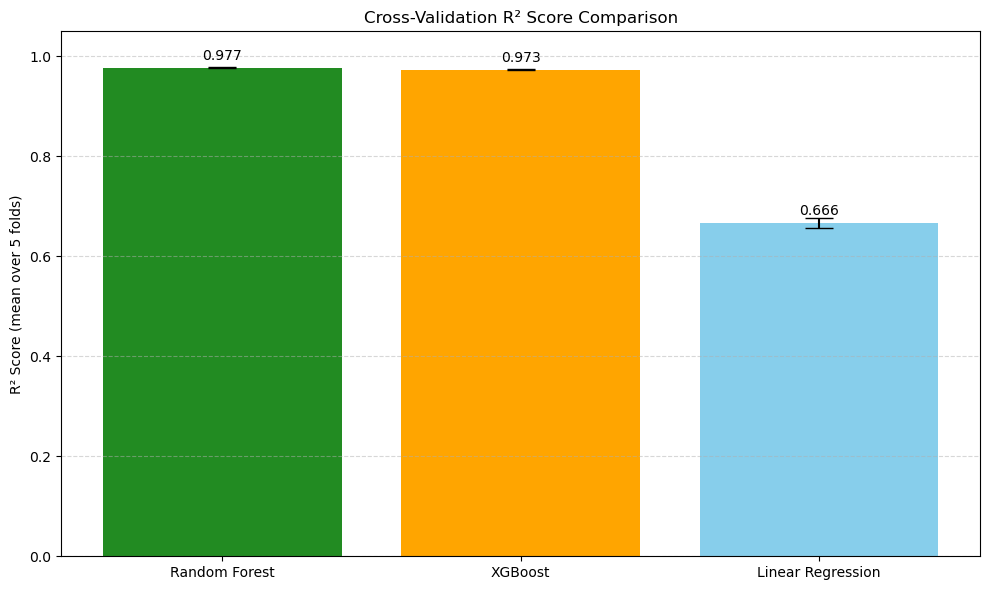

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Data
model_names = ['Random Forest', 'XGBoost', 'Linear Regression']
mean_r2_scores = [
    np.mean(rf_cv_scores),
    np.mean(xgb_cv_scores),
    np.mean(lr_cv_scores)
]
std_devs = [
    np.std(rf_cv_scores),
    np.std(xgb_cv_scores),
    np.std(lr_cv_scores)
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mean_r2_scores, yerr=std_devs, capsize=10, color=['forestgreen', 'orange', 'skyblue'])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}', ha='center', va='bottom')

# Formatting
plt.title("Cross-Validation R² Score Comparison")
plt.ylabel("R² Score (mean over 5 folds)")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


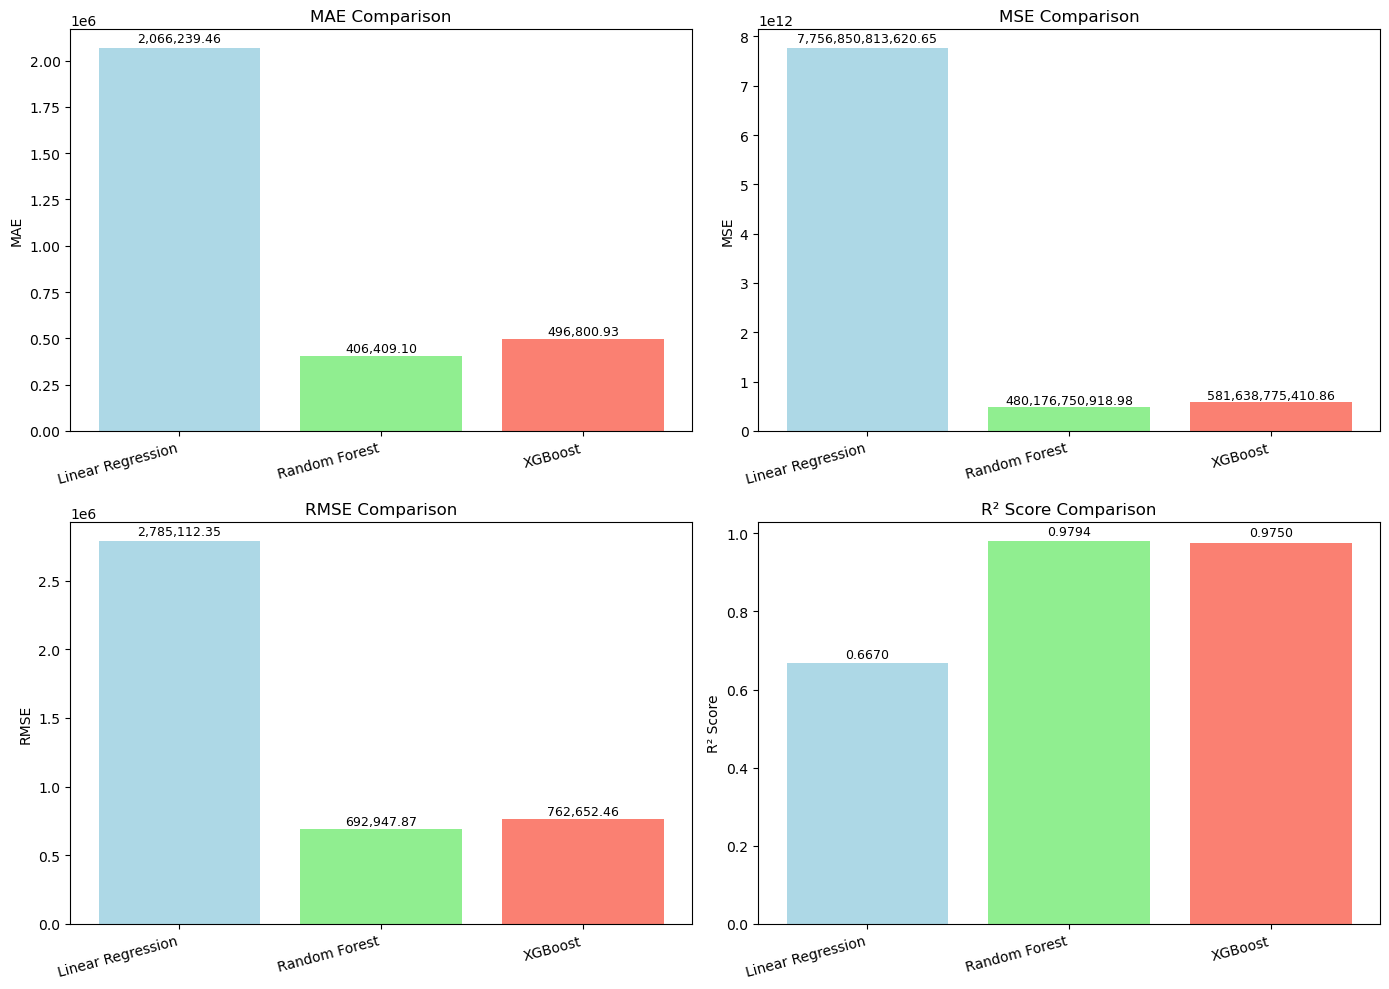

In [99]:
# 🔹 Make predictions using trained models
LinearRegrModel_pred = LinearRegrModel.predict(X_test)
randomModel_pred = randomModel.predict(X_test)
XGBModel_pred = XGBModel.predict(X_test)

# 🔹 Step 1: Define a function to compute evaluation metrics
def evaluate_metrics(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# 🔹 Step 2: Evaluate each model
linear_metrics = evaluate_metrics("Linear Regression", y_test, LinearRegrModel_pred)
rf_metrics = evaluate_metrics("Random Forest", y_test, randomModel_pred)
xgb_metrics = evaluate_metrics("XGBoost", y_test, XGBModel_pred)

# 🔹 Step 3: Organize results
model_names = [linear_metrics['Model'], rf_metrics['Model'], xgb_metrics['Model']]
mae_scores = [linear_metrics['MAE'], rf_metrics['MAE'], xgb_metrics['MAE']]
mse_scores = [linear_metrics['MSE'], rf_metrics['MSE'], xgb_metrics['MSE']]
rmse_scores = [linear_metrics['RMSE'], rf_metrics['RMSE'], xgb_metrics['RMSE']]
r2_scores = [linear_metrics['R2'], rf_metrics['R2'], xgb_metrics['R2']]

results = {
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores,
    "R² Score": r2_scores
}

# 🔹 Step 4: Plot metrics
colors = ['lightblue', 'lightgreen', 'salmon']
plt.figure(figsize=(14, 10))

for i, (metric_name, scores) in enumerate(results.items(), 1):
    ax = plt.subplot(2, 2, i)
    bars = ax.bar(range(len(model_names)), scores, color=colors)
    ax.set_title(f"{metric_name} Comparison")
    ax.set_ylabel(metric_name)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=15, ha='right')

    # Format numbers for readability
    for bar in bars:
        h = bar.get_height()
        label = f"{h:.4f}" if metric_name == "R² Score" else f"{h:,.2f}"
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01 * h, label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("Model_Regression_Metric_Comparison.png", dpi=300)
plt.show()


In [100]:
print(imsData.columns.tolist())


['MemberID', 'SavingTimesPerPeriod', 'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade', 'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear', 'EmploymentStatus', 'HasGuardian', 'Age', 'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan', 'BoostAmount', 'AllowedLoan', 'AvgSavingPerCycle', 'RemainingCycles', 'RemainingRatio', 'MembershipYears', 'IkiminaAge', 'MembershipRatio', 'IsEmployed', 'SavingFrequency_daily', 'SavingFrequency_monthly', 'SavingFrequency_weekly', 'RecentLoanPaymentStatus_Bad', 'RecentLoanPaymentStatus_Better', 'RecentLoanPaymentStatus_Excellent', 'RecentLoanPaymentStatus_Good', 'RecentLoanPaymentStatus_Poor']


In [101]:
pkl.dump(randomModel, open('randomModel_Loan_prediction_model.pkl', 'wb'))

In [102]:
pkl.dump(LinearRegrModel, open('LinearRegrModel_Loan_prediction_model.pkl', 'wb'))

In [103]:
pkl.dump(XGBModel, open('XGBModel_Loan_prediction_model.pkl', 'wb'))

In [104]:
randomModel = pkl.load(open('randomModel_Loan_prediction_model.pkl', 'rb'))

In [105]:
XGBModel = pkl.load(open('XGBModel_Loan_prediction_model.pkl', 'rb'))

In [106]:
LinearRegrModel = pkl.load(open('LinearRegrModel_Loan_prediction_model.pkl', 'rb'))


In [107]:
randomModel

RandomForestRegressor(random_state=42)

In [108]:
LinearRegrModel

LinearRegression()

In [109]:
XGBModel

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [111]:
import gradio as gr
import pandas as pd
import pickle as pkl

# Load trained models once globally for performance
randomModel = pkl.load(open('randomModel_Loan_prediction_model.pkl', 'rb'))
xgbModel = pkl.load(open('xgbModel_Loan_prediction_model.pkl', 'rb'))
linearRegrModel = pkl.load(open('LinearRegrModel_Loan_prediction_model.pkl', 'rb'))

guardian_map = {True: 1, False: 0}

feature_columns = [
    'SavingTimesPerPeriod',
    'TotalSavingCycles',
    'CompletedSavingCycles',
    'UserSavingsMade',
    'TotalCurrentSaving',
    'IkiminaCreatedYear',
    'UserJoinedYear',
    'HasGuardian',
    'SavingFrequency_daily',
    'SavingFrequency_weekly',
    'SavingFrequency_monthly',
    'RecentLoanPaymentStatus_Excellent',
    'RecentLoanPaymentStatus_Better',
    'RecentLoanPaymentStatus_Good',
    'RecentLoanPaymentStatus_Bad',
    'RecentLoanPaymentStatus_Poor'
]

# Enable this flag to turn on debug logging
DEBUG = False

def log_debug(*args):
    if DEBUG:
        print(*args)

def predict_loan(
    saving_frequency,
    saving_times_per_period,
    total_saving_cycles,
    completed_saving_cycles,
    user_savings_made,
    total_current_saving,
    has_guardian,
    recent_loan_payment_status,
    user_joined_year,
    ikimina_created_year,
    model_choice
):
    try:
        # Validate all numeric inputs are int or float and non-negative
        numeric_inputs = {
            "Saving Times Per Period": saving_times_per_period,
            "Total Saving Cycles": total_saving_cycles,
            "Completed Saving Cycles": completed_saving_cycles,
            "User Savings Made": user_savings_made,
            "Total Current Saving": total_current_saving,
            "User Joined Year": user_joined_year,
            "Ikimina Created Year": ikimina_created_year,
        }
        for name, value in numeric_inputs.items():
            if not isinstance(value, (int, float)):
                return f"❌ {name} must be a number."
            if value < 0:
                return f"❌ {name} must be non-negative."

        # Logical validation: user joined year cannot be before Ikimina created year
        if user_joined_year < ikimina_created_year:
            return "❌ User Joined Year cannot be earlier than Ikimina Created Year."

        # Validate saving frequency and times per period constraints
        valid_freq = ['daily', 'weekly', 'monthly']
        if saving_frequency not in valid_freq:
            return f"❌ Saving Frequency must be one of {valid_freq}."

        if saving_frequency == 'daily' and saving_times_per_period != 1:
            return "❌ For daily frequency, Saving Times Per Period must be exactly 1."
        if saving_frequency == 'weekly' and not (1 <= saving_times_per_period <= 7):
            return "❌ For weekly frequency, Saving Times Per Period must be between 1 and 7."
        if saving_frequency == 'monthly' and not (1 <= saving_times_per_period <= 31):
            return "❌ For monthly frequency, Saving Times Per Period must be between 1 and 31."

        # Validate recent loan payment status
        valid_loan_status = ['Excellent', 'Better', 'Good', 'Bad', 'Poor']
        if recent_loan_payment_status not in valid_loan_status:
            return f"❌ Recent Loan Payment Status must be one of {valid_loan_status}."

        # Prepare feature vector with one-hot encoding
        features = [
            int(saving_times_per_period),
            int(total_saving_cycles),
            int(completed_saving_cycles),
            int(user_savings_made),
            float(total_current_saving),
            int(ikimina_created_year),
            int(user_joined_year),
            guardian_map.get(has_guardian, 0),  # fallback to 0 if unknown
            1 if saving_frequency == 'daily' else 0,
            1 if saving_frequency == 'weekly' else 0,
            1 if saving_frequency == 'monthly' else 0,
            1 if recent_loan_payment_status == 'Excellent' else 0,
            1 if recent_loan_payment_status == 'Better' else 0,
            1 if recent_loan_payment_status == 'Good' else 0,
            1 if recent_loan_payment_status == 'Bad' else 0,
            1 if recent_loan_payment_status == 'Poor' else 0,
        ]

        log_debug("Feature vector:", features)

        df = pd.DataFrame([features], columns=feature_columns)

        # Select model
        models = {
            'Random Forest': randomModel,
            'XGBoost': xgbModel,
            'Linear Regression': linearRegrModel
        }
        model = models.get(model_choice)
        if model is None:
            return "❌ Invalid model selected."

        # Perform prediction
        prediction = model.predict(df)[0]
        log_debug(f"Raw prediction: {prediction}")

        # Ensure non-negative prediction (loan amount cannot be negative)
        prediction = max(prediction, 0)

        return f"✅ Predicted Allowed Loan: {prediction:,.2f} RWF"

    except Exception as e:
        # Catch all unexpected errors gracefully
        return f"❌ Error during prediction: {str(e)}"


# Gradio interface code remains the same
iface = gr.Interface(
    fn=predict_loan,
    inputs=[
        gr.Radio(['daily', 'monthly', 'weekly'], label="Saving Frequency", value="daily"),
        gr.Number(value=1, label="Saving Times Per Period", precision=0),
        gr.Number(value=24, label="Total Saving Cycles", precision=0),
        gr.Number(value=12, label="Completed Saving Cycles", precision=0),
        gr.Number(value=10, label="User Savings Made", precision=0),
        gr.Number(value=500000, label="Total Current Saving"),
        gr.Checkbox(label="Has Guardian", value=False),
        gr.Radio(['Excellent', 'Better', 'Good', 'Bad', 'Poor'], label="Recent Loan Payment Status", value="Excellent"),
        gr.Number(value=2020, label="User Joined Year", precision=0),
        gr.Number(value=2015, label="Ikimina Created Year", precision=0),
        gr.Radio(['Random Forest', 'XGBoost', 'Linear Regression'], label="Select Model", value="Random Forest"),
    ],
    outputs=gr.Textbox(label="Loan Prediction Result"),
    title="IMS Loan Allowed Prediction",
    description="Predict the allowed loan amount for an IMS user based on saving history and membership profile.",
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
